# Rede de Filiação
Dados do dataset 2020 que tenham relação com as vacinas Coronavac, Astrazeneca, Moderna, Janssen, Pfizer.

In [1]:
# Instalar pycairo, igraph e depois importar bibliotecas
import igraph as ig
import numpy as np
import os
import json
import pandas as pd 
import csv
import math
from igraph import Graph, plot
import random

In [2]:
df = pd.read_csv("..\Jupyter Notebook\COVID19Dataset\metadata.csv", low_memory=False)

In [3]:
#Criação de uma variável auxiliar que pega o dado que interessa do csv importado e não pega os valores nulos desse campo
df_notna_aux1 = df[df['abstract'].notna()]

#Da váriavel auxiliar anterior pega os autores
df_notna_aux2 = df_notna_aux1[df_notna_aux1['authors'].notna()]

#Da anterior pega a data de publicação
df_notna_aux3 = df_notna_aux2[df_notna_aux2['publish_time'].notna()]

#Da anterior pega o arquivo json 
df_notna = df_notna_aux3.loc[df_notna_aux2['pdf_json_files'].notna()]

#Converte o formato de plublish_time 
df_notna = df_notna.copy()
df_notna.loc[:, 'publish_time'] = pd.to_datetime(df_notna['publish_time'], errors='coerce').copy()

#filtra o ano de 2020 somente
df_ano = df_notna[(df_notna['publish_time'] >= '2020-01-01 00:00:00') & (df_notna['publish_time'] <= '2021-01-01 00:00:00')]

#filtro com os nomes de pelo menos uma das vacinas
df_finalizado = df_ano.loc[df_notna['abstract'].str.contains("Coronavac|Astrazeneca|Moderna|Janssen|Pfizer", case=False)]

print("Número de artigos DFFinalizado: ",len(df_finalizado))
print("Número de artigos DFNotNA: ",len(df_notna))

C:\Users\sarah\AppData\Local\Temp\ipykernel_12308\1166508786.py:15: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_notna.loc[:, 'publish_time'] = pd.to_datetime(df_notna['publish_time'], errors='coerce').copy()


Número de artigos DFFinalizado:  66
Número de artigos DFNotNA:  325855


In [4]:
#Aqui é feita a união de caminho de diretório de forma portável, armazenando os caminhos completos em uma lista
datafiles = []
for filename in df_finalizado['pdf_json_files']:
    ifile = os.path.join('..\Jupyter Notebook\COVID19Dataset', filename)
    datafiles.append(ifile)
    
with open(datafiles[0],'r')as f:
    doc = json.load(f)

In [5]:
novabib = []

for file in datafiles:
    try:
        with open(file, 'r') as f:
            doc = json.load(f)
        
        id = doc['paper_id']
        title = doc['metadata']['title']
        abstract = doc['abstract']
        
        authors_doc = []
        for author in doc['metadata']['authors']:
            first = author['first']
            middle = author.get('middle', None)
            last = author['last']
            suffix = author.get('suffix', None)
            
            affiliation = author.get('affiliation', {})
            laboratory = affiliation.get('laboratory', None)
            institution = affiliation.get('institution', None)
            
            location = affiliation.get('location', {})
            settlement = location.get('settlement', None)
            region = location.get('region', None)
            country = location.get('country', None)
            
            email = author.get('email', None)
            
            authors_doc.append({
                'first': first,
                'middle': middle,
                'last': last,
                'suffix': suffix,
                'affiliation': {
                    'laboratory': laboratory,
                    'institution': institution,
                    'location': {
                        'settlement': settlement,
                        'region': region,
                        'country': country
                    }
                },
                'email': email
            })
        
        bibEntries = []
        for key, value in doc['bib_entries'].items():
            refid = key
            bib_title = value['title']
            
            authors_bib = []
            for author in value['authors']:
                first = author['first']
                middle = author.get('middle', None)
                last = author['last']
                suffix = author.get('suffix', None)
                
                authors_bib.append({
                    'first': first,
                    'middle': middle,
                    'last': last,
                    'suffix': suffix
                })
            
            year = value['year']
            
            try:
                DOI = value['other_ids']['DOI'][0]
            except KeyError:
                DOI = np.nan
            
            bibEntries.append({
                'refid_bib': refid,
                'title': bib_title,
                'authors_bib': authors_bib,
                'year': year,
                'DOI': DOI
            })
        
        novabib.append({
            'id': id,
            'abstract': abstract,
            'title': title,
            'authors_doc': authors_doc,
            'bib': bibEntries
        })
    except:
        pass


In [7]:
# Removendo caso tenha instituições vazias
for entry in novabib:
    authors = entry['authors_doc']
    authors_valid = []

    for author in authors:
        affiliation = author['affiliation']
        if affiliation.get('institution'):
            authors_valid.append(author)   
    # Atualizar a lista de autores com afiliação válida na entrada
    entry['authors_doc'] = authors_valid

novabib = [entry for entry in novabib if entry['authors_doc']]

In [8]:
df = pd.DataFrame(novabib)
df.to_csv('novabib.csv', index=False)

In [58]:
# Rede de Filiacao
institution_links = {}

for entry in novabib:
    authors = entry['authors_doc']

    for i in range(len(authors)):
        for j in range(i + 1, len(authors)):
            author1 = authors[i]
            author2 = authors[j]

            affiliation1 = author1['affiliation']
            affiliation2 = author2['affiliation']

            # Verifica se as afiliações são diferentes e não são None
            if affiliation1 is not None and affiliation2 is not None and affiliation1 != affiliation2:
                institution1 = affiliation1['institution'] or ''
                institution2 = affiliation2['institution'] or ''

                # Verificar e adicionar a ligação apenas se institution1 não for igual a institution2
                if institution1 != institution2:
                    # Gera a chave única para a ligação entre instituições
                    link_key = tuple(sorted([institution1, institution2]))

                    # Incrementa o contador da ligação no dicionário ou adiciona a ligação com contador igual a 1
                    institution_links[link_key] = institution_links.get(link_key, 0) + 1

with open('redeFiliacao.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['institution1', 'institution2', 'num'])

    for link, count in institution_links.items():
        institution1, institution2 = link
        writer.writerow([institution1, institution2, count])

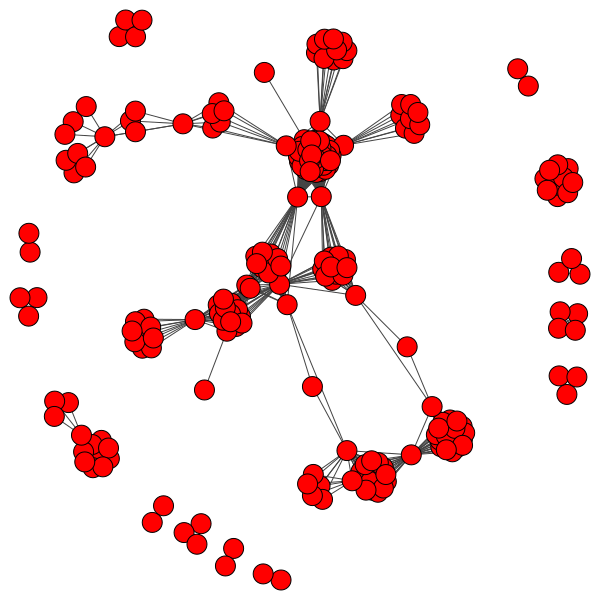

In [83]:
links = []
with open('redeFiliacao.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        institution1 = row['institution1']
        institution2 = row['institution2']
        num = int(row['num'])
        links.append((institution1, institution2, num))

nodes = set()  # Usando um conjunto para garantir nós únicos
for link in links:
    nodes.add(link[0])
    nodes.add(link[1])

node_indices = {node: i for i, node in enumerate(nodes)}

edges = []
edge_widths = []
for link in links:
    institution1, institution2, num = link
    if institution1 != institution2:
        edge = (node_indices[institution1], node_indices[institution2])
        if edge not in edges and (edge[1], edge[0]) not in edges:
            edges.append(edge)
            edge_widths.append(math.log(num))

gFiliacao = Graph()
gFiliacao.add_vertices(len(nodes))
gFiliacao.add_edges(edges)

gFiliacao.vs["name"] = list(nodes)
#gFiliacao.vs["label"] = ''
#gFiliacao.vs["label"] = gFiliacao.vs["name"]  # Adiciona as instituições como rótulos dos nós

# Calcula o tamanho logarítmico dos nós
#node_sizes = [math.log(gFiliacao.degree(node))+10 for node in gFiliacao.vs]
#gFiliacao.vs["size"] = node_sizes

# Calcula a escala logarítmica das arestas
#edge_widths = [width for width in edge_widths]
#gFiliacao.es["width"] = edge_widths

layout = gFiliacao.layout_fruchterman_reingold()
plot(gFiliacao, layout=layout)

# Betweenness

In [68]:
gFiliacaoBetweenness = gFiliacao.copy()
betweenness = gFiliacaoBetweenness.betweenness()

In [69]:
# Calcule o máximo e o mínimo do betweenness
max_betweenness = max(betweenness)
min_betweenness = min(betweenness)
print(min_betweenness)
print(max_betweenness)

# Aplique a escala de 0 a 1 ao betweenness
scaled_betweenness = [(b - min_betweenness) / (max_betweenness - min_betweenness) for b in betweenness]

0.0
4888.499999999999


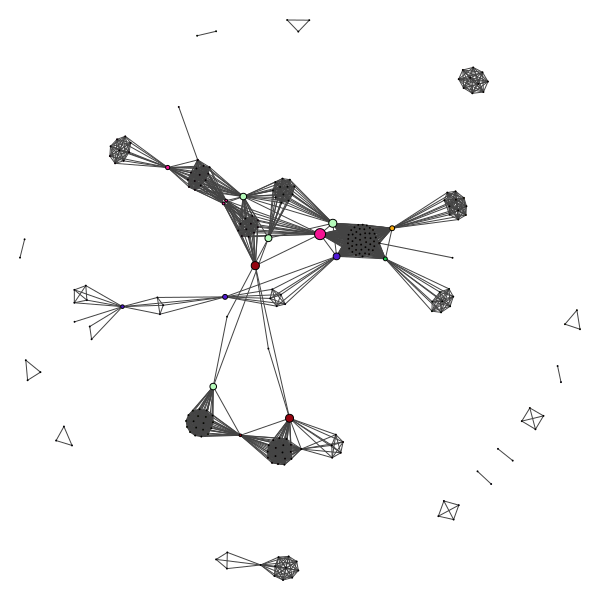

In [81]:
# Define o tamanho dos nós com base no betweenness escalado
gFiliacaoBetweenness.vs["size"] = [1 + 10 * b for b in scaled_betweenness]

layout = gFiliacaoBetweenness.layout_fruchterman_reingold()
plot(gFiliacaoBetweenness, layout=layout)

# Degree

In [74]:
gFiliacaoDegree = gFiliacao.copy()
node_degrees = gFiliacaoDegree.degree()

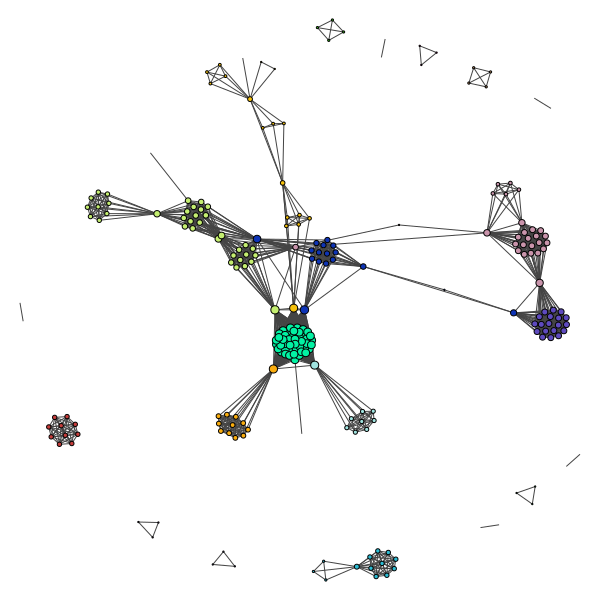

In [80]:
gFiliacaoDegree.vs["size"] = [math.log(degree) * 2 for degree in node_degrees]
layout = gFiliacaoDegree.layout_fruchterman_reingold()
plot(gFiliacaoDegree, layout=layout)

# Colorir com comunidades

In [60]:
color_palette = []

# Função para gerar uma cor aleatória em formato hexadecimal
def cor_aleatoria():
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return "#{:02X}{:02X}{:02X}".format(r, g, b)

# Gerar 185 cores aleatórias e adicioná-las à paleta (existem 183 nós no grafo de citações)
for _ in range(50):
    color_palette.append(cor_aleatoria())

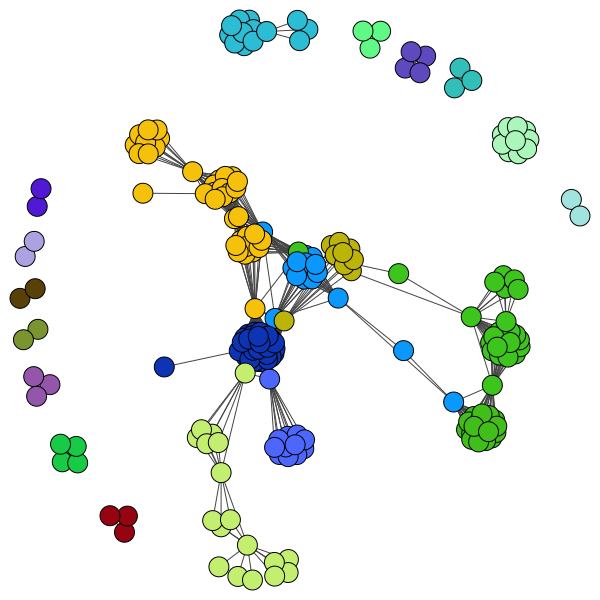

In [84]:
available_colors = color_palette.copy()  # Cria uma cópia da lista de cores

# Executar o algoritmo fastgreedy para identificar os clusters
communities = gFiliacao.community_fastgreedy()
clusters = communities.as_clustering()

# Criar um dicionário para mapear o número do cluster para uma cor aleatória e faz a verificação se todas foram usadas para poder repetir
cluster_to_color = {}
for cluster_num in range(len(clusters)):
    if(len(available_colors)>0):
        color = random.choice(available_colors)
        available_colors.remove(color)
    if(len(available_colors)==0):
        available_colors=color_palette
    cluster_to_color[cluster_num] = color

# Definir as cores dos nós com base nos clusters
gFiliacao.vs["color"] = [cluster_to_color[cluster_num] for cluster_num in clusters.membership]

# Plotar o grafo
layout = gFiliacao.layout_fruchterman_reingold()
plot(gFiliacao, layout=layout)

In [79]:
#Para visualizar melhor
gFiliacaoDegree.vs["label"] = ''
gFiliacaoBetweenness.vs["label"] = ''
gFiliacao.vs["label"] = ''